<a href="https://colab.research.google.com/github/RoshaniPawar16/AAI/blob/main/Task1/Deep_Q_Learning_Task_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Q-Learning

The main idea behind Q-learning is that if we had a function

> Indented block


$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

But this is not scalable. Must compute $Q(s,a)$ for every state-action pair. If state is e.g. current game state pixels, computationally infeasible to compute for entire state space! But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`__. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}



### Double Deep Q-Learning

We will implement Double Deep Q-Learning here. Double Deep Q-Learning is used to reduce the maximaztion bias in Q-Learning. This entails using two separate $Q$-value estimators, each of which is used to update the other. The target values are calculated using a target Q-network. The target Q-network's parameters are updated to the current networks every $C$ time steps.

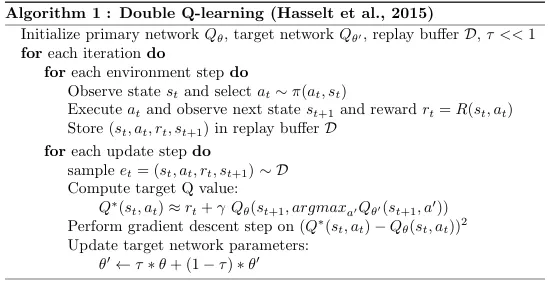

[Image Source](https://towardsdatascience.com/double-deep-q-networks-905dd8325412)

In [ ]:
!pip install gym --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 9.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827621 sha256=f98e21ee1c9337d1a0f39bfc88cbc429cbf595d1aad3c6b80f4b0e2133bba82d
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.9 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [ ]:
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
import time
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from tqdm import tqdm

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

array([[[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]],

       [[180, 200, 230],
        [204, 230, 255],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       ...,

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [235, 245, 249],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]]], dtype=uint8)
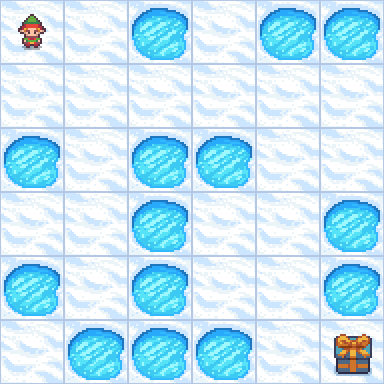

In [ ]:
# Create the environment
random_map = generate_random_map(size=6, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map,render_mode="rgb_array", is_slippery=True)
env.reset()
env.render()

In [ ]:
# Named tuple representing a single transition in our environment
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

# Cyclic buffer of bounded size that holds and samples the transitions observed recently
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
nspace = env.observation_space.n
naction = env.action_space.n
print(nspace)

36


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            # nn.Linear(256, 256),
            # nn.ReLU(),
            # nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, action_dim)
        )

        # Initialize weights using Xavier/Glorot initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.network(x)

# class DQN(nn.Module):
#     def __init__(self, input_shape, out_actions):
#         super().__init__()

#         # https://poloclub.github.io/cnn-explainer/
#         self.conv_block1 = nn.Sequential(
#             nn.Conv2d(in_channels=input_shape, out_channels=10, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )

#         self.conv_block2 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )

#         self.layer_stack = nn.Sequential(
#             nn.Flatten(), # flatten inputs into a single vector
#             # After flattening the matrix into a vector, pass it to the output layer. To determine the input shape, use the print() statement in forward()
#             nn.Linear(in_features=10*1*1, out_features=out_actions)
#         )

#     def forward(self, x):
#         # current x is (32,100)
#         x = x.unsqueeze(0)
#         x = x.unsqueeze(1)
#         x = self.conv_block1(x)
#         x = self.conv_block2(x)
#         # print(x.shape)  # Use this to determine input shape of the output layer.
#         x = self.layer_stack(x)
#         return x

In [ ]:
def get_action(state, epsilon):
  ## First we randomize a number
  exp_exp_tradeoff = random.uniform(0, 1)
  ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
  if exp_exp_tradeoff > epsilon:
    with torch.no_grad():
      action = policy_net(state).max(1)[1].view(1, 1)

  # Else doing a random choice --> exploration
  else:
    action = env.action_space.sample()
    action = torch.tensor([action], device=device).view(1, 1)
  return action
    #exploration

In [ ]:
# Here, we will specify the hyperparameters

total_episodes = 10000         # Total training episodes
max_steps = 1000              # Max steps per episode
learning_rate = 1e-3         # Learning rate
gamma = 0.9                   # Discounting rate
batch_size = 32              # Training Batch size
target_update = 5            # Target network update frequency
train_frequency = 1           # Train Q network every train_frquency episodes
train_epochs = 2             # Training epochs during each training cycle

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 0.01/3          # Exponential decay rate for exploration prob

In [ ]:
policy_net = DQN(nspace, naction).to(device)
target_net = DQN(nspace, naction).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr = learning_rate)

# Initialize the replay buffer
memory = ReplayMemory(10000)

In [ ]:
def one_hot_encode(state, num_classes):
  one_hot_array = np.zeros(num_classes, dtype=np.float32)
  one_hot_array[state] = 1
  return one_hot_array

In [ ]:
def trainDQN(policy_net, target_net, optimizer, epsilon, total_episodes, memory):

  # List of rewards
  rewards = []
  for episode in tqdm(range(1, total_episodes+1)):
      # Initialize the environment and state
      state , prob = env.reset()
      state = one_hot_encode(state, nspace)
      state = torch.tensor([state], device=device)
      total_rewards = 0
      for _ in range(max_steps):
          # Select and perform an action
          action = get_action(state, epsilon)
          next_state, reward, done, _, _ = env.step(action.item())

          next_state = one_hot_encode(next_state, nspace)

          total_rewards += reward

          reward = torch.tensor([reward], device=device)
          done = torch.tensor([int(done)], device=device)
          next_state = torch.tensor([next_state], device=device)

          # Store the transition in memory
          memory.push(state, action, next_state, reward, done)

          # Move to the next state
          state = next_state

          if done:
              break

      # optimize the policy
      if episode % train_frequency == 0 and len(memory) >= batch_size:
        total_loss = 0
        for _ in range(train_epochs):
          # get samples from experience replay memory
          transitions = memory.sample(batch_size)
          # unroll and reroll to get them in proper format
          batch = Transition(*zip(*transitions))

          state_batch = torch.cat(batch.state)
          action_batch = torch.cat(batch.action)
          next_state_batch = torch.cat(batch.next_state)
          reward_batch = torch.cat(batch.reward)
          done_batch = torch.cat(batch.done)

          # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
          # columns of actions taken
          state_action_values = policy_net(state_batch).gather(1, action_batch)

          # Compute V(s_{t+1}) for all next states and get the max q values.
          with torch.no_grad():
            next_state_values = target_net(next_state_batch).max(1)[0].detach()
          # Compute the target Q values
          target_q_values = (next_state_values * (1-done_batch) * gamma) + reward_batch

          # Compute Huber loss
          loss = F.smooth_l1_loss(state_action_values, target_q_values.unsqueeze(1))

          # Optimize the model
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()


      # Update the target network
      if episode % target_update == 0:
          target_net.load_state_dict(policy_net.state_dict())

      # Reduce epsilon (because we need less and less exploration)
      epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
      rewards.append(total_rewards)
      if episode % 1000 == 0:
        print(f"Episode {episode}: Reward = {total_rewards}, Epsilon = {epsilon}")
      # print(f"Episode {episode}: Reward = {total_rewards}, Epsilon = {epsilon}")

  print ("Score over time: " +  str(sum(rewards)/total_episodes))
  return rewards

In [ ]:
rewards = trainDQN(policy_net, target_net, optimizer, epsilon, total_episodes, memory)

 10%|█         | 1012/10000 [00:08<01:55, 77.71it/s]

Episode 1000: Reward = 0.0, Epsilon = 0.04531725341377987


 20%|██        | 2015/10000 [00:17<01:09, 115.72it/s]

Episode 2000: Reward = 0.0, Epsilon = 0.01125990746332641


 30%|███       | 3026/10000 [00:27<00:56, 123.22it/s]

Episode 3000: Reward = 0.0, Epsilon = 0.010044945930464861


 40%|████      | 4023/10000 [00:36<00:47, 126.62it/s]

Episode 4000: Reward = 0.0, Epsilon = 0.010001603400824389


 50%|█████     | 5015/10000 [00:44<00:53, 93.50it/s]

Episode 5000: Reward = 0.0, Epsilon = 0.010000057199710342


 60%|██████    | 6023/10000 [00:53<00:33, 117.92it/s]

Episode 6000: Reward = 0.0, Epsilon = 0.010000002040542086


 70%|███████   | 7022/10000 [01:03<00:27, 109.02it/s]

Episode 7000: Reward = 0.0, Epsilon = 0.010000000072794285


 80%|████████  | 8018/10000 [01:11<00:17, 112.44it/s]

Episode 8000: Reward = 0.0, Epsilon = 0.010000000002596864


 90%|█████████ | 9021/10000 [01:20<00:08, 114.41it/s]

Episode 9000: Reward = 0.0, Epsilon = 0.010000000000092641


100%|██████████| 10000/10000 [01:30<00:00, 111.10it/s]

Episode 10000: Reward = 0.0, Epsilon = 0.010000000000003305
Score over time: 0.0002


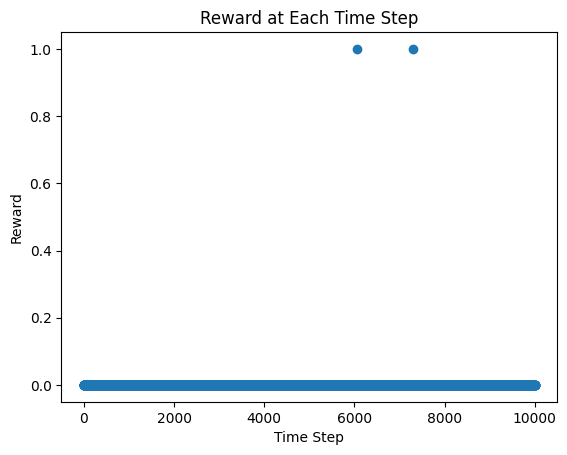

In [ ]:
plt.plot(rewards, 'o')
plt.xlabel('Time Step')
plt.ylabel('Reward')
plt.title('Reward at Each Time Step')
plt.show()

Really good results! Accuracy of 43%

In [ ]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state, prob = env.reset()
    state = one_hot_encode(state, nspace)
    state = torch.tensor([state], device=device)
    done = False
    epsilon = 0
    tl = 0
    max_steps = 500000
    for t in range(max_steps):
        vid.capture_frame()
        with torch.no_grad():
            action = policy_net(state).max(1)[1].view(1, 1)
        next_state, reward, done, info, _ = env.step(action.item())
        next_state = one_hot_encode(next_state, nspace)
        tl+=reward
        next_state = torch.tensor([next_state], device=device)
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()
    print(tl)

In [ ]:
show_video_of_model("FrozenLake-v1")

Moviepy - Building video video/FrozenLake-v1.mp4.
Moviepy - Writing video video/FrozenLake-v1.mp4



Moviepy - Done !
Moviepy - video ready video/FrozenLake-v1.mp4
0.0


In [ ]:
show_video("FrozenLake-v1")

In [1]:
!pip install gym --upgrade

array([[[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[180, 200, 230],
        [204, 230, 255],
        [204, 230, 255],
        ...,
        [180, 200, 230],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[180, 200, 230],
        [235, 245, 249],
        [204, 230, 255],
        ...,
        [180, 200, 230],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]], dtype=uint8)
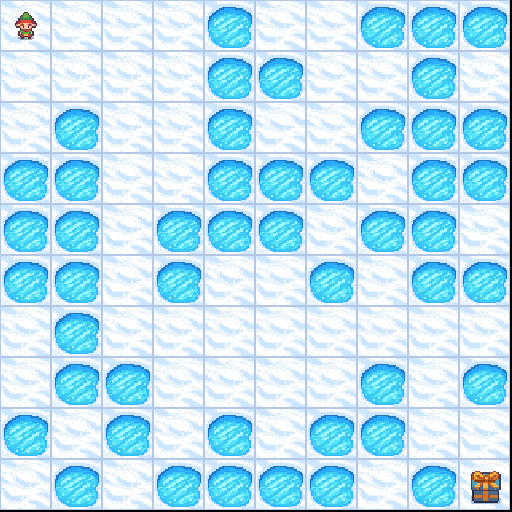

In [3]:
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
import time
import math
import random
import numpy as np
np.random.seed(4)
random_map = generate_random_map(size=10, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map, render_mode="rgb_array", is_slippery=True)
env.reset()
env.render()

In [ ]:
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
import time
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from tqdm import tqdm
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(4)
torch.manual_seed(4)

# Create the environment with is_slippery=True
random_map = generate_random_map(size=10, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map, render_mode="rgb_array", is_slippery=True)
env.reset()
env.render()

# Named tuple representing a single transition in our environment
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

nspace = env.observation_space.n
naction = env.action_space.n
print(nspace)

# Cyclic buffer of bounded size that holds and samples the transitions observed recently
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.priorty = []
        self.position = 0
        self.alpha = 0.6

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        # return random.sample(self.memory, batch_size)
        indices = np.random.choice(len(self.memory), batch_size, replace=False, p=None)
        return [self.memory[i] for i in indices]

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, action_dim)
            # nn.Linear(state_dim, action_dim)
        )

        # Initialize weights using Xavier/Glorot initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.network(x)

def get_action(state, epsilon):
    exp_exp_tradeoff = random.uniform(0, 1)
    if exp_exp_tradeoff > epsilon:
        with torch.no_grad():
            action = policy_net(state).max(1)[1].view(1, 1)
    else:
        # action = torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
        action = env.action_space.sample()
        action = torch.tensor(np.array(action), device=device).view(1, 1)
    return action

# Hyperparameters
total_episodes = 5000*10
max_steps = 500
learning_rate = 1e-4
gamma = 0.6
batch_size = 64
target_update = 50
train_frequency = 10
train_epochs = 10
goal_position = env.observation_space.n - 1  # Goal is the last position in the grid

# Exploration parameters
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.0001

policy_net = DQN(nspace, naction).to(device)
target_net = DQN(nspace, naction).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=learning_rate, weight_decay=1e-5)

# Initialize the replay buffer
memory = ReplayMemory(500000)

def one_hot_encode(state, num_classes):
    one_hot_array = np.zeros(num_classes, dtype=np.float32)
    one_hot_array[state] = 1
    return one_hot_array

# Manhattan distance heuristic to guide the agent towards the goal
def manhattan_distance(state):
    grid_size = int(np.sqrt(nspace))
    state_x, state_y = state % grid_size, state // grid_size
    goal_x, goal_y = goal_position % grid_size, goal_position // grid_size
    return abs(goal_x - state_x) + abs(goal_y - state_y)


def trainDQN(policy_net, target_net, optimizer, epsilon, total_episodes, memory):
    rewards = []
    steps_moved = []
    new_rewards = []
    for episode in tqdm(range(1, total_episodes + 1)):
        current_state, _ = env.reset()
        state = one_hot_encode(current_state, nspace)
        state = torch.tensor(np.array([state]), device=device)
        total_rewards = 0
        actual_rewards = 0
        total_steps = 0
        visited_states = set()
        visited_states.add(current_state)
        for step in range(max_steps):
            action = get_action(state, epsilon)
            next_state, org_reward, done, _, _ = env.step(action.item())

            # Reward shaping (adjusted for simplicity)
            if done:
                reward = 100 if org_reward == 1 else -100
            else:
                # distance_to_goal = manhattan_distance(current_state)
                # next_distance_to_goal = manhattan_distance(next_state)

                # Reward for getting closer to the goal
                reward = 0
                # if next_distance_to_goal < distance_to_goal:
                #     reward = 2.0  # Double the reward for moving closer
                # elif next_distance_to_goal > distance_to_goal:
                #     reward = -0.1 * next_distance_to_goal  # Minor penalty for moving away from the goal

                # Additional checks to avoid loops and repeated states
                # if next_state in visited_states: #or next_state < current_state:
                #     reward -= 1.0  # Penalty for revisiting states to avoid loops
                # else:
                #     reward += 0.5  # Small reward for exploring new states

                visited_states.add(next_state)  # Track visited states to prevent loops

            next_state = one_hot_encode(next_state, nspace)
            total_rewards += org_reward
            actual_rewards += org_reward
            total_steps += 1

            reward = torch.tensor(np.array([reward]), device=device)
            done = torch.tensor(np.array([int(done)]), device=device)
            next_state = torch.tensor(np.array([next_state]), device=device)

            memory.push(state, action, next_state, reward, done)

            state = next_state

            if done:
                break

        if episode % train_frequency == 0 and len(memory) >= batch_size:
            for _ in range(train_epochs):
                transitions = memory.sample(batch_size)
                batch = Transition(*zip(*transitions))

                state_batch = torch.cat(batch.state)
                action_batch = torch.cat(batch.action)
                next_state_batch = torch.cat(batch.next_state)
                reward_batch = torch.cat(batch.reward)
                done_batch = torch.cat(batch.done)

                # Current Q values for chosen actions
                state_action_values = policy_net(state_batch).gather(1, action_batch)

                # Double DQN: action selection by policy_net, evaluation by target_net
                with torch.no_grad():
                    next_actions = policy_net(next_state_batch).max(1)[1].unsqueeze(1)
                    next_state_values = target_net(next_state_batch).gather(1, next_actions).squeeze()

                # Calculate the target Q values
                target_q_values = (next_state_values * (1 - done_batch) * gamma) + reward_batch

                # Loss calculation and backpropagation
                loss = F.smooth_l1_loss(state_action_values, target_q_values.unsqueeze(1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        rewards.append(total_rewards)
        steps_moved.append(total_steps)
        new_rewards.append(actual_rewards)
        if episode % 1000 == 0:
            print(f"Episode {episode}: Reward = {total_rewards}, Epsilon = {epsilon}, Steps = {total_steps}, Adjusted Reward = {actual_rewards}")
            os.makedirs("checkpoints", exist_ok=True)
            torch.save(policy_net.state_dict(), f'checkpoints/policy_net-{episode}.pth')
            torch.save(target_net.state_dict(), f'checkpoints/target_net-{episode}.pth')

    print("Score over time: " + str(sum(rewards) / total_episodes))
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.tight_layout(pad=4.0)

    # Plot Reward at Each Episode
    axes[0, 0].plot(rewards)
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Reward')
    axes[0, 0].set_title('Reward at Each Episode')

    # Plot Steps Moved at Each Episode
    axes[0, 1].plot(steps_moved)
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Steps Moved')
    axes[0, 1].set_title('Steps Moved at Each Episode')

    # Plot Adjusted Reward at Each Episode
    axes[1, 0].plot(new_rewards)
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Adjusted Reward')
    axes[1, 0].set_title('Adjusted Reward at Each Episode')

    # Plot Reward at Each Episode (Moving Average)
    moving_average = np.convolve(rewards, np.ones(1000) / 1000, mode='valid')
    axes[1, 1].plot(moving_average)
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Reward')
    axes[1, 1].set_title('Reward at Each Episode (Moving Average)')

    # Plot Adjusted Reward at Each Episode (Moving Average)
    moving_average = np.convolve(new_rewards, np.ones(1000) / 1000, mode='valid')
    axes[2, 0].plot(moving_average)
    axes[2, 0].set_xlabel('Episode')
    axes[2, 0].set_ylabel('Reward')
    axes[2, 0].set_title('Adjusted Reward at Each Episode (Moving Average)')

    # Plot Steps Moved at Each Episode (Moving Average)
    moving_average = np.convolve(steps_moved, np.ones(1000) / 1000, mode='valid')
    axes[2, 1].plot(moving_average)
    axes[2, 1].set_xlabel('Episode')
    axes[2, 1].set_ylabel('Steps Moved')
    axes[2, 1].set_title('Steps Moved at Each Episode (Moving Average)')

    plt.show()

    return rewards

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state, prob = env.reset()
    state = one_hot_encode(state, nspace)
    state = torch.tensor(np.array([state]), device=device)
    done = False
    epsilon = 0
    tl = 0
    max_steps = 500
    policy_net.load_state_dict(torch.load(f'checkpoints/policy_net-{total_episodes}.pth'))
    for t in range(max_steps+1):
        vid.capture_frame()
        with torch.no_grad():
            action = policy_net(state).max(1)[1].view(1, 1)
        next_state, reward, done, info, _ = env.step(action.item())
        next_state = one_hot_encode(next_state, nspace)
        tl+=reward
        next_state = torch.tensor(np.array([next_state]), device=device)
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        # break in the next iteration

    vid.close()
    env.close()
    print("Final reward:", tl)
    return tl

rewards = trainDQN(policy_net, target_net, optimizer, epsilon, total_episodes, memory)

show_video_of_model("FrozenLake-v1")

show_video("FrozenLake-v1")

100


  2%|▏         | 1000/50000 [00:18<17:02, 47.90it/s]

Episode 1000: Reward = 0.0, Epsilon = 0.9057890438555999, Steps = 7, Adjusted Reward = 0.0


  4%|▍         | 2010/50000 [00:34<12:38, 63.30it/s]

Episode 2000: Reward = 0.0, Epsilon = 0.820543445547202, Steps = 41, Adjusted Reward = 0.0


  6%|▌         | 3010/50000 [00:50<12:00, 65.22it/s]

Episode 3000: Reward = 0.0, Epsilon = 0.7434100384749007, Steps = 6, Adjusted Reward = 0.0


  8%|▊         | 4010/50000 [01:08<12:42, 60.34it/s]

Episode 4000: Reward = 0.0, Epsilon = 0.6736168455752829, Steps = 3, Adjusted Reward = 0.0


 10%|█         | 5010/50000 [01:27<15:33, 48.19it/s]

Episode 5000: Reward = 0.0, Epsilon = 0.6104653531155071, Steps = 15, Adjusted Reward = 0.0


 12%|█▏        | 6010/50000 [01:47<13:41, 53.55it/s]

Episode 6000: Reward = 0.0, Epsilon = 0.5533235197330861, Steps = 10, Adjusted Reward = 0.0


 14%|█▍        | 7002/50000 [02:10<17:27, 41.06it/s]

Episode 7000: Reward = 0.0, Epsilon = 0.5016194507534953, Steps = 134, Adjusted Reward = 0.0


 16%|█▌        | 8007/50000 [02:33<21:09, 33.08it/s]

Episode 8000: Reward = 0.0, Epsilon = 0.45483567447604933, Steps = 28, Adjusted Reward = 0.0


 18%|█▊        | 9000/50000 [02:58<17:32, 38.94it/s]

Episode 9000: Reward = 0.0, Epsilon = 0.4125039631431931, Steps = 29, Adjusted Reward = 0.0


 20%|██        | 10000/50000 [03:26<18:31, 35.99it/s]

Episode 10000: Reward = 0.0, Epsilon = 0.3742006467597279, Steps = 64, Adjusted Reward = 0.0


 22%|██▏       | 11005/50000 [03:56<23:49, 27.28it/s]

Episode 11000: Reward = 0.0, Epsilon = 0.3395423728610988, Steps = 59, Adjusted Reward = 0.0


 24%|██▍       | 12008/50000 [04:28<18:07, 34.93it/s]

Episode 12000: Reward = 0.0, Epsilon = 0.3081822697930801, Steps = 19, Adjusted Reward = 0.0


 26%|██▌       | 13004/50000 [05:01<20:02, 30.77it/s]

Episode 13000: Reward = 0.0, Epsilon = 0.27980647510367246, Steps = 7, Adjusted Reward = 0.0


 28%|██▊       | 14007/50000 [05:39<19:01, 31.52it/s]

Episode 14000: Reward = 0.0, Epsilon = 0.2541309943021904, Steps = 99, Adjusted Reward = 0.0


 30%|███       | 15004/50000 [06:17<18:31, 31.49it/s]

Episode 15000: Reward = 0.0, Epsilon = 0.23089885854694553, Steps = 19, Adjusted Reward = 0.0


 32%|███▏      | 16003/50000 [06:59<27:47, 20.39it/s]

Episode 16000: Reward = 0.0, Epsilon = 0.20987755281470882, Steps = 119, Adjusted Reward = 0.0


 34%|███▍      | 17006/50000 [07:47<27:55, 19.69it/s]

Episode 17000: Reward = 0.0, Epsilon = 0.19085668881220727, Steps = 72, Adjusted Reward = 0.0


 36%|███▌      | 18007/50000 [08:34<22:06, 24.12it/s]

Episode 18000: Reward = 0.0, Epsilon = 0.17364589933937066, Steps = 26, Adjusted Reward = 0.0


 38%|███▊      | 19005/50000 [09:26<21:15, 24.30it/s]

Episode 19000: Reward = 0.0, Epsilon = 0.1580729330304087, Steps = 9, Adjusted Reward = 0.0


 40%|████      | 20005/50000 [10:20<21:49, 22.91it/s]

Episode 20000: Reward = 0.0, Epsilon = 0.1439819304042466, Steps = 30, Adjusted Reward = 0.0


 42%|████▏     | 21008/50000 [11:16<21:39, 22.31it/s]

Episode 21000: Reward = 0.0, Epsilon = 0.13123186397045208, Steps = 146, Adjusted Reward = 0.0


 44%|████▍     | 22004/50000 [12:15<33:13, 14.05it/s]

Episode 22000: Reward = 0.0, Epsilon = 0.11969512677871053, Steps = 28, Adjusted Reward = 0.0


 46%|████▌     | 23003/50000 [13:14<24:48, 18.14it/s]

Episode 23000: Reward = 0.0, Epsilon = 0.10925625528557566, Steps = 70, Adjusted Reward = 0.0


 48%|████▊     | 24002/50000 [14:16<42:55, 10.09it/s]

Episode 24000: Reward = 0.0, Epsilon = 0.09981077375651838, Steps = 28, Adjusted Reward = 0.0


 50%|█████     | 25007/50000 [15:18<19:00, 21.92it/s]

Episode 25000: Reward = 0.0, Epsilon = 0.0912641486376598, Steps = 10, Adjusted Reward = 0.0


 52%|█████▏    | 26006/50000 [16:21<17:04, 23.42it/s]

Episode 26000: Reward = 0.0, Epsilon = 0.08353084243219053, Steps = 38, Adjusted Reward = 0.0


 54%|█████▍    | 27004/50000 [17:27<20:16, 18.90it/s]

Episode 27000: Reward = 0.0, Epsilon = 0.07653345761235225, Steps = 10, Adjusted Reward = 0.0


 56%|█████▌    | 28004/50000 [18:33<23:20, 15.70it/s]

Episode 28000: Reward = 0.0, Epsilon = 0.07020196199896576, Steps = 38, Adjusted Reward = 0.0


 58%|█████▊    | 29001/50000 [19:42<22:46, 15.37it/s]

Episode 29000: Reward = 0.0, Epsilon = 0.06447298785584314, Steps = 17, Adjusted Reward = 0.0


 60%|██████    | 30004/50000 [20:51<25:27, 13.09it/s]

Episode 30000: Reward = 0.0, Epsilon = 0.05928919768418531, Steps = 50, Adjusted Reward = 0.0


 62%|██████▏   | 31001/50000 [22:02<22:59, 13.77it/s]

Episode 31000: Reward = 0.0, Epsilon = 0.05459871036962222, Steps = 139, Adjusted Reward = 0.0


 64%|██████▍   | 32002/50000 [23:15<22:48, 13.15it/s]

Episode 32000: Reward = 0.0, Epsilon = 0.05035458193858255, Steps = 145, Adjusted Reward = 0.0


 66%|██████▌   | 33004/50000 [24:26<17:30, 16.17it/s]

Episode 33000: Reward = 0.0, Epsilon = 0.046514335727227595, Steps = 60, Adjusted Reward = 0.0


 68%|██████▊   | 34003/50000 [25:37<17:32, 15.20it/s]

Episode 34000: Reward = 0.0, Epsilon = 0.04303953726072281, Steps = 45, Adjusted Reward = 0.0


 70%|███████   | 35001/50000 [26:54<27:18,  9.16it/s]

Episode 35000: Reward = 0.0, Epsilon = 0.039895409588095315, Steps = 200, Adjusted Reward = 0.0


 72%|███████▏  | 36002/50000 [28:11<17:41, 13.19it/s]

Episode 36000: Reward = 0.0, Epsilon = 0.03705048522281963, Steps = 94, Adjusted Reward = 0.0


 74%|███████▍  | 37007/50000 [29:24<11:17, 19.17it/s]

Episode 37000: Reward = 0.0, Epsilon = 0.034476291205635994, Steps = 39, Adjusted Reward = 0.0


 76%|███████▌  | 38005/50000 [30:38<16:50, 11.87it/s]

Episode 38000: Reward = 0.0, Epsilon = 0.03214706413760394, Steps = 73, Adjusted Reward = 0.0


 78%|███████▊  | 39003/50000 [31:57<19:38,  9.33it/s]

Episode 39000: Reward = 0.0, Epsilon = 0.03003949233134634, Steps = 175, Adjusted Reward = 0.0


 80%|████████  | 40001/50000 [33:19<17:22,  9.59it/s]

Episode 40000: Reward = 0.0, Epsilon = 0.028132482499846838, Steps = 89, Adjusted Reward = 0.0


 82%|████████▏ | 41003/50000 [34:44<11:54, 12.59it/s]

Episode 41000: Reward = 0.0, Epsilon = 0.026406948647743622, Steps = 123, Adjusted Reward = 0.0


 84%|████████▍ | 42002/50000 [36:07<10:12, 13.06it/s]

Episode 42000: Reward = 0.0, Epsilon = 0.024845621052272927, Steps = 10, Adjusted Reward = 0.0


 86%|████████▌ | 43002/50000 [37:30<09:51, 11.84it/s]

Episode 43000: Reward = 0.0, Epsilon = 0.023432873422078924, Steps = 200, Adjusted Reward = 0.0


 88%|████████▊ | 44001/50000 [38:59<10:59,  9.09it/s]

Episode 44000: Reward = 0.0, Epsilon = 0.02215456650403775, Steps = 200, Adjusted Reward = 0.0


 90%|█████████ | 45003/50000 [40:25<07:03, 11.79it/s]

Episode 45000: Reward = 0.0, Epsilon = 0.02099790657285988, Steps = 200, Adjusted Reward = 0.0


 92%|█████████▏| 46004/50000 [41:47<04:35, 14.52it/s]

Episode 46000: Reward = 0.0, Epsilon = 0.01995131738718724, Steps = 12, Adjusted Reward = 0.0


 94%|█████████▍| 47001/50000 [43:11<06:28,  7.73it/s]

Episode 47000: Reward = 0.0, Epsilon = 0.019004324330678855, Steps = 200, Adjusted Reward = 0.0


 94%|█████████▍| 47051/50000 [43:16<04:37, 10.63it/s]

In [14]:
show_video_of_model("FrozenLake-v1")

show_video("FrozenLake-v1")

<ipython-input-13-d7ddaa5231da>:321: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load(f'checkpoints/policy_net-{total_episodes}.pth'))


Moviepy - Building video video/FrozenLake-v1.mp4.
Moviepy - Writing video video/FrozenLake-v1.mp4



Moviepy - Done !
Moviepy - video ready video/FrozenLake-v1.mp4
Final reward: 0.0


  0%|          | 0/500000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  2%|▏         | 10451/500000 [00:02<02:17, 3552.68it/s]

Episode 10000: Total Reward = -100, Epsilon = 0.9048369656147537


  4%|▍         | 20390/500000 [00:05<02:39, 3005.78it/s]

Episode 20000: Total Reward = -100, Epsilon = 0.8187299343429234


  6%|▌         | 30736/500000 [00:08<01:57, 3981.01it/s]

Episode 30000: Total Reward = -99.4, Epsilon = 0.7408171094488248


  8%|▊         | 40543/500000 [00:10<01:48, 4225.65it/s]

Episode 40000: Total Reward = -99.5, Epsilon = 0.6703187053891713


 10%|█         | 50478/500000 [00:13<02:09, 3458.69it/s]

Episode 50000: Total Reward = -101.4, Epsilon = 0.606529143379149


 12%|█▏        | 60651/500000 [00:15<01:34, 4631.59it/s]

Episode 60000: Total Reward = -100.5, Epsilon = 0.5488099896521104


 14%|█▍        | 70462/500000 [00:18<02:19, 3085.91it/s]

Episode 70000: Total Reward = -99.5, Epsilon = 0.4965835657358831


 16%|█▌        | 80641/500000 [00:21<01:40, 4170.18it/s]

Episode 80000: Total Reward = -100, Epsilon = 0.44932716679461515


 18%|█▊        | 91221/500000 [00:24<01:45, 3871.70it/s]

Episode 90000: Total Reward = -100.3, Epsilon = 0.4065678301707155


 20%|██        | 100626/500000 [00:26<01:32, 4329.16it/s]

Episode 100000: Total Reward = -103.8, Epsilon = 0.3678776017682482


 22%|██▏       | 110618/500000 [00:28<01:29, 4344.42it/s]

Episode 110000: Total Reward = -99.5, Epsilon = 0.3328692529016169


 24%|██▍       | 120327/500000 [00:31<01:56, 3250.09it/s]

Episode 120000: Total Reward = -92.5, Epsilon = 0.3011924047419503


 26%|██▌       | 130676/500000 [00:34<01:52, 3271.31it/s]

Episode 130000: Total Reward = -94.6, Epsilon = 0.27253002157291667


 28%|██▊       | 140673/500000 [00:37<01:44, 3425.17it/s]

Episode 140000: Total Reward = -95.0, Epsilon = 0.2465952377589643


 30%|███       | 150669/500000 [00:39<01:40, 3469.97it/s]

Episode 150000: Total Reward = -95.0, Epsilon = 0.2231284866688706


 32%|███▏      | 160505/500000 [00:42<01:10, 4827.17it/s]

Episode 160000: Total Reward = -100.5, Epsilon = 0.20189490281967454


 34%|███▍      | 170632/500000 [00:45<01:51, 2962.67it/s]

Episode 170000: Total Reward = -100, Epsilon = 0.18268197124044036


 36%|███▌      | 180381/500000 [00:47<01:35, 3341.57it/s]

Episode 180000: Total Reward = -97.5, Epsilon = 0.16529740052972253


 38%|███▊      | 190916/500000 [00:50<01:06, 4654.75it/s]

Episode 190000: Total Reward = -100.9, Epsilon = 0.14956719831932092


 40%|████      | 200468/500000 [00:52<01:13, 4076.34it/s]

Episode 200000: Total Reward = -105.2, Epsilon = 0.13533392988275578


 42%|████▏     | 211109/500000 [00:55<01:00, 4805.56it/s]

Episode 210000: Total Reward = -100, Epsilon = 0.1224551424598337


 44%|████▍     | 220822/500000 [00:57<01:04, 4331.91it/s]

Episode 220000: Total Reward = -105.0, Epsilon = 0.11080193952727901


 46%|████▌     | 230637/500000 [01:00<01:18, 3424.86it/s]

Episode 230000: Total Reward = -97.4, Epsilon = 0.1002576907460938


 48%|████▊     | 240419/500000 [01:03<01:21, 3181.05it/s]

Episode 240000: Total Reward = -96.1, Epsilon = 0.1


 50%|█████     | 250399/500000 [01:06<01:11, 3513.81it/s]

Episode 250000: Total Reward = -96.9, Epsilon = 0.1


 52%|█████▏    | 260838/500000 [01:08<00:53, 4453.96it/s]

Episode 260000: Total Reward = -100.5, Epsilon = 0.1


 54%|█████▍    | 270645/500000 [01:11<00:50, 4515.66it/s]

Episode 270000: Total Reward = -98.3, Epsilon = 0.1


 56%|█████▌    | 280647/500000 [01:13<00:59, 3683.77it/s]

Episode 280000: Total Reward = -100, Epsilon = 0.1


 58%|█████▊    | 290615/500000 [01:16<01:06, 3143.16it/s]

Episode 290000: Total Reward = -96.0, Epsilon = 0.1


 60%|██████    | 300514/500000 [01:19<00:53, 3722.67it/s]

Episode 300000: Total Reward = -99.5, Epsilon = 0.1


 62%|██████▏   | 310770/500000 [01:21<00:44, 4224.73it/s]

Episode 310000: Total Reward = -100.5, Epsilon = 0.1


 64%|██████▍   | 320716/500000 [01:24<00:42, 4199.64it/s]

Episode 320000: Total Reward = -95.0, Epsilon = 0.1


 66%|██████▌   | 330539/500000 [01:26<00:33, 5045.75it/s]

Episode 330000: Total Reward = -97.3, Epsilon = 0.1


 68%|██████▊   | 340415/500000 [01:29<00:44, 3552.81it/s]

Episode 340000: Total Reward = -96.5, Epsilon = 0.1


 70%|███████   | 350548/500000 [01:32<00:37, 3972.22it/s]

Episode 350000: Total Reward = -102.3, Epsilon = 0.1


 72%|███████▏  | 360757/500000 [01:35<00:38, 3606.11it/s]

Episode 360000: Total Reward = -99.5, Epsilon = 0.1


 74%|███████▍  | 370541/500000 [01:37<00:38, 3402.90it/s]

Episode 370000: Total Reward = -96.6, Epsilon = 0.1


 76%|███████▌  | 380708/500000 [01:39<00:32, 3637.19it/s]

Episode 380000: Total Reward = -90.5, Epsilon = 0.1


 78%|███████▊  | 390431/500000 [01:42<00:31, 3470.53it/s]

Episode 390000: Total Reward = -89.9, Epsilon = 0.1


 80%|████████  | 400600/500000 [01:46<00:34, 2917.69it/s]

Episode 400000: Total Reward = -103.8, Epsilon = 0.1


 82%|████████▏ | 410536/500000 [01:48<00:20, 4283.86it/s]

Episode 410000: Total Reward = -103.5, Epsilon = 0.1


 84%|████████▍ | 420709/500000 [01:51<00:21, 3694.99it/s]

Episode 420000: Total Reward = -100, Epsilon = 0.1


 86%|████████▌ | 430370/500000 [01:53<00:14, 4732.86it/s]

Episode 430000: Total Reward = -98.5, Epsilon = 0.1


 88%|████████▊ | 440702/500000 [01:56<00:13, 4464.56it/s]

Episode 440000: Total Reward = -102.8, Epsilon = 0.1


 90%|█████████ | 450492/500000 [01:59<00:18, 2706.61it/s]

Episode 450000: Total Reward = -99.5, Epsilon = 0.1


 92%|█████████▏| 460546/500000 [02:01<00:09, 4093.76it/s]

Episode 460000: Total Reward = -95.2, Epsilon = 0.1


 94%|█████████▍| 470433/500000 [02:04<00:06, 4317.69it/s]

Episode 470000: Total Reward = -100, Epsilon = 0.1


 96%|█████████▌| 480535/500000 [02:06<00:04, 4218.63it/s]

Episode 480000: Total Reward = -101.5, Epsilon = 0.1


 98%|█████████▊| 490659/500000 [02:09<00:02, 3546.85it/s]

Episode 490000: Total Reward = -100, Epsilon = 0.1


100%|██████████| 500000/500000 [02:11<00:00, 3796.21it/s]


Episode 500000: Total Reward = -96.5, Epsilon = 0.1


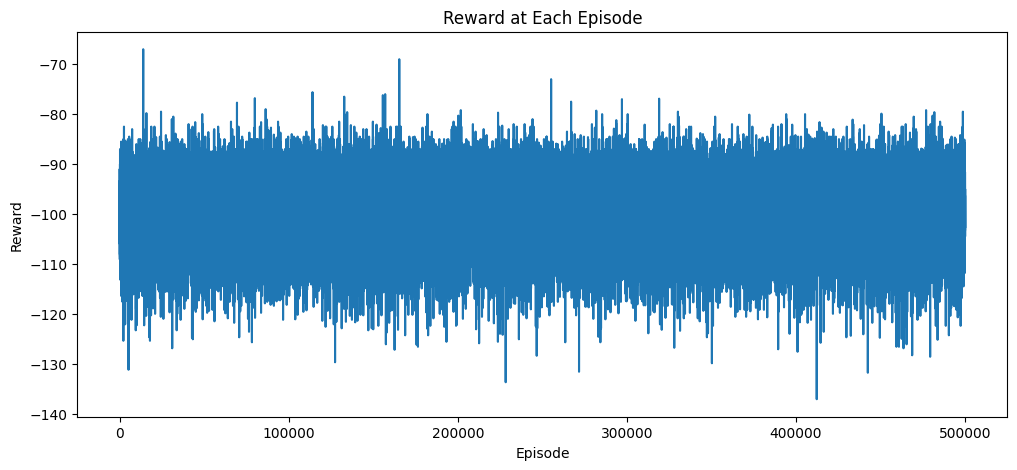

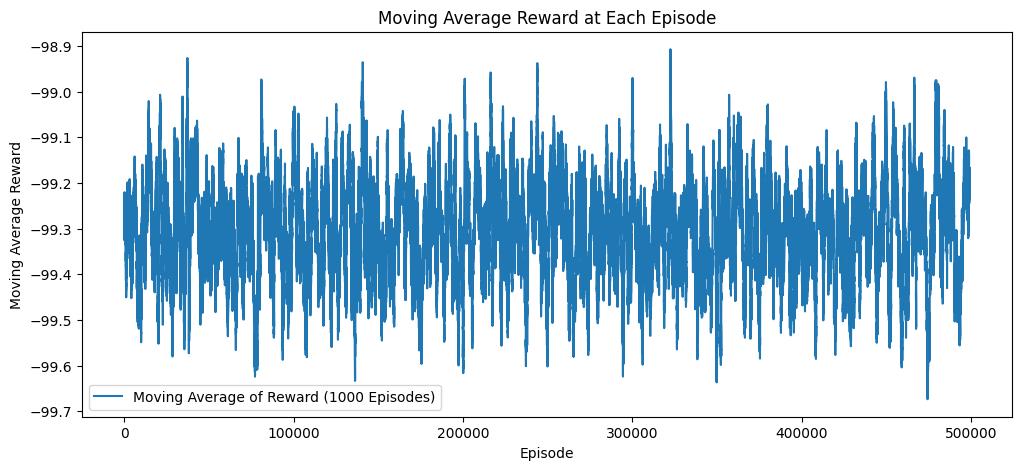

Moviepy - Building video video/FrozenLake-v1.mp4.
Moviepy - Writing video video/FrozenLake-v1.mp4



Moviepy - Done !
Moviepy - video ready video/FrozenLake-v1.mp4
Total reward: 0.0


In [ ]:
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
import numpy as np
import random
from collections import namedtuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import base64, io, os
from IPython.display import HTML, display

np.random.seed(442)
# Set up the environment
random_map = generate_random_map(size=10, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map, render_mode="rgb_array", is_slippery=True)
env.reset()

# Hyperparameters
total_episodes = 100000*5
max_steps = 500
learning_rate = 0.01
gamma = 0.9
epsilon = 1.0
min_epsilon = 0.1
decay_rate = 0.00001
goal_position = env.observation_space.n - 1  # Goal is the last position in the grid

# Q-table initialization
nspace = env.observation_space.n
naction = env.action_space.n
Q_table = np.zeros((nspace, naction))

# Heuristic function - Manhattan distance to the goal
def manhattan_distance(state):
    grid_size = int(np.sqrt(nspace))
    state_x, state_y = state % grid_size, state // grid_size
    goal_x, goal_y = goal_position % grid_size, goal_position // grid_size
    return abs(goal_x - state_x) + abs(goal_y - state_y)

# Modified epsilon-greedy policy with heuristic
def get_action(state):
    if random.uniform(0, 1) < epsilon:
        return env.action_space.sample()
    else:
        # Bias actions that reduce the Manhattan distance to the goal
        heuristic_values = [
            Q_table[state, a] - 0.1 * manhattan_distance(state + a)
            for a in range(naction)
        ]
        return np.argmax(heuristic_values)

# Training function
def train_agent(Q_table, total_episodes, epsilon):
    rewards = []
    for episode in tqdm(range(total_episodes)):
        state, _ = env.reset()
        total_reward = 0
        done = False
        visited_states = set()

        for step in range(max_steps):
            action = get_action(state)
            next_state, org_reward, done, _, _ = env.step(action)

            # Modify reward based on progress
            if done:
                  reward = 100 if org_reward == 1 else -100
            else:
                  distance_to_goal = manhattan_distance(state)
                  next_distance_to_goal = manhattan_distance(next_state)

                  # Reward for getting closer to the goal
                  reward = 0
                  if next_distance_to_goal < distance_to_goal:
                      reward = 2.0  # Double the reward for moving closer
                  elif next_distance_to_goal > distance_to_goal:
                      reward = -0.1 * next_distance_to_goal  # Minor penalty for moving away from the goal

                  # Additional checks to avoid loops and repeated states
                  if next_state in visited_states or next_state < state:
                      reward -= 1.0  # Penalty for revisiting states to avoid loops
                  else:
                      reward += 0.5  # Small reward for exploring new states

                  visited_states.add(next_state)  # Track visited states to prevent loops

            # Q-learning update
            old_value = Q_table[state, action]
            next_max = np.max(Q_table[next_state])
            Q_table[state, action] = old_value + learning_rate * (reward + gamma * next_max - old_value)

            state = next_state
            total_reward += reward
            if done:
                break

        # Decay epsilon
        epsilon = max(min_epsilon, epsilon * (1 - decay_rate))
        rewards.append(total_reward)

        if (episode + 1) % 10000 == 0:
            print(f"Episode {episode + 1}: Total Reward = {total_reward}, Epsilon = {epsilon}")

    # Plot rewards over episodes
    plt.figure(figsize=(12, 5))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward at Each Episode')
    plt.show()
    moving_average = np.convolve(rewards, np.ones(1000)/1000, mode='valid')
    plt.figure(figsize=(12, 5))
    plt.plot(moving_average, label="Moving Average of Reward (1000 Episodes)")
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.title('Moving Average Reward at Each Episode')
    plt.legend()
    plt.show()
    return Q_table, rewards

# Record and display video
def show_video_of_model(env_name, Q_table):
    from gym.wrappers.monitoring import video_recorder
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state, _ = env.reset()
    total_reward = 0

    for t in range(max_steps):
        vid.capture_frame()
        action = np.argmax(Q_table[state])  # Exploit learned policy
        state, reward, done, _, _ = env.step(action)
        total_reward += reward
        # if done:
        #     break

    vid.close()
    env.close()
    print("Total reward:", total_reward)

    video_path = f"video/{env_name}.mp4"
    if os.path.exists(video_path):
        with open(video_path, "rb") as video_file:
            encoded_video = base64.b64encode(video_file.read()).decode("ascii")
        display(HTML(f"""
            <video width="600" height="400" controls>
                <source src="data:video/mp4;base64,{encoded_video}" type="video/mp4">
            </video>
        """))
    else:
        print("Video not found.")

# Train the agent and display the learned policy
Q_table, rewards = train_agent(Q_table, total_episodes, epsilon)
show_video_of_model("FrozenLake-v1", Q_table)


  5%|▌         | 10502/200000 [00:03<01:05, 2903.46it/s]

Episode 10000, Epsilon: 0.9048, Last Reward: -10


 10%|█         | 20643/200000 [00:06<00:57, 3106.66it/s]

Episode 20000, Epsilon: 0.8187, Last Reward: -13.6


 15%|█▌        | 30423/200000 [00:09<00:48, 3486.53it/s]

Episode 30000, Epsilon: 0.7408, Last Reward: -10.6


 20%|██        | 40298/200000 [00:13<01:06, 2383.73it/s]

Episode 40000, Epsilon: 0.6703, Last Reward: -13.6


 25%|██▌       | 50225/200000 [00:17<01:12, 2066.31it/s]

Episode 50000, Epsilon: 0.6065, Last Reward: -13.6


 30%|███       | 60379/200000 [00:21<01:04, 2154.58it/s]

Episode 60000, Epsilon: 0.5488, Last Reward: -10


 35%|███▌      | 70245/200000 [00:26<01:02, 2090.77it/s]

Episode 70000, Epsilon: 0.4966, Last Reward: -13.6


 40%|████      | 80285/200000 [00:30<01:06, 1792.62it/s]

Episode 80000, Epsilon: 0.4493, Last Reward: -4.0


 45%|████▌     | 90229/200000 [00:36<00:59, 1832.32it/s]

Episode 90000, Epsilon: 0.4066, Last Reward: -7.6


 50%|█████     | 100416/200000 [00:42<00:50, 1969.98it/s]

Episode 100000, Epsilon: 0.3679, Last Reward: -10.1


 55%|█████▌    | 110120/200000 [00:48<01:17, 1163.78it/s]

Episode 110000, Epsilon: 0.3329, Last Reward: -11.8


 60%|██████    | 120300/200000 [00:54<00:44, 1787.86it/s]

Episode 120000, Epsilon: 0.3012, Last Reward: -13.1


 65%|██████▌   | 130126/200000 [01:00<00:51, 1366.18it/s]

Episode 130000, Epsilon: 0.2725, Last Reward: -12.1


 70%|███████   | 140315/200000 [01:08<00:38, 1561.09it/s]

Episode 140000, Epsilon: 0.2466, Last Reward: -10


 75%|███████▌  | 150163/200000 [01:15<00:50, 993.30it/s] 

Episode 150000, Epsilon: 0.2231, Last Reward: -15.6


 80%|████████  | 160151/200000 [01:24<00:41, 965.29it/s]

Episode 160000, Epsilon: 0.2019, Last Reward: -10


 85%|████████▌ | 170236/200000 [01:33<00:26, 1111.32it/s]

Episode 170000, Epsilon: 0.1827, Last Reward: -4.0


 90%|█████████ | 180161/200000 [01:41<00:17, 1150.09it/s]

Episode 180000, Epsilon: 0.1653, Last Reward: -15.6


 95%|█████████▌| 190108/200000 [01:50<00:08, 1108.57it/s]

Episode 190000, Epsilon: 0.1496, Last Reward: -13.6


100%|██████████| 200000/200000 [02:01<00:00, 1648.44it/s]


Episode 200000, Epsilon: 0.1353, Last Reward: -18.8


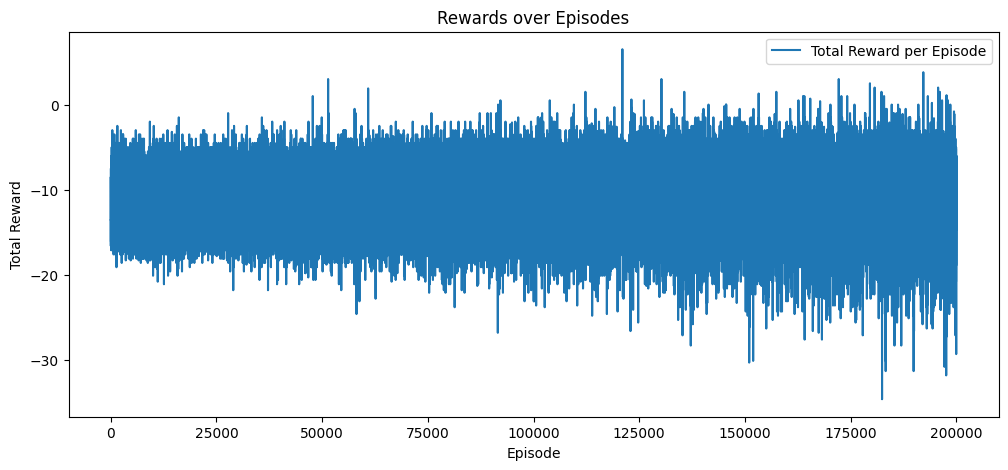

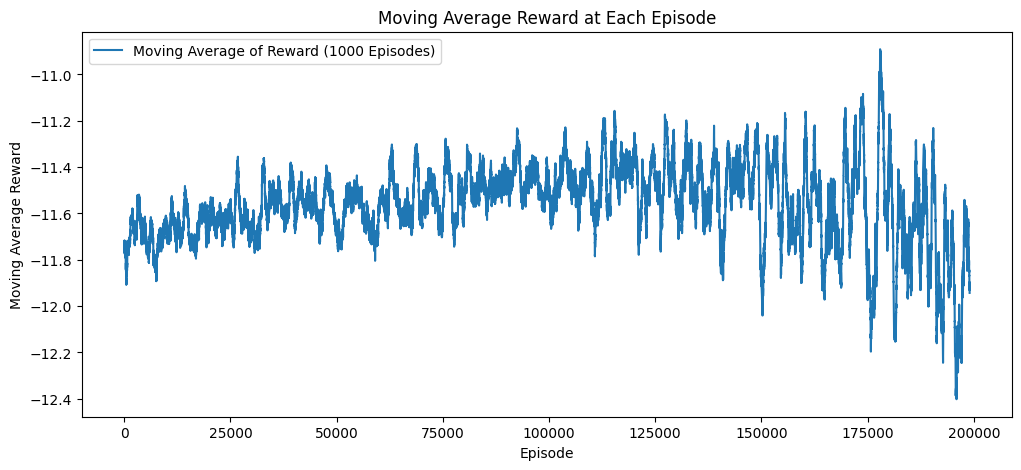

Moviepy - Building video video/FrozenLake-v1.mp4.
Moviepy - Writing video video/FrozenLake-v1.mp4



Moviepy - Done !
Moviepy - video ready video/FrozenLake-v1.mp4
Total reward: 0.0


In [ ]:
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import base64, io, os
from IPython.display import HTML, display

# Set seed for reproducibility
np.random.seed(442)

# Set up the environment
random_map = generate_random_map(size=10, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map, render_mode="rgb_array", is_slippery=False)
env.reset()

# Hyperparameters
total_episodes = 100000*2
max_steps = 500
learning_rate = 0.1
gamma = 0.9
epsilon = 1.0
min_epsilon = 0.1
decay_rate = 0.00001
goal_position = env.observation_space.n - 1  # Goal is the last position in the grid

# Q-table initialization
nspace = env.observation_space.n
naction = env.action_space.n
Q_table = np.zeros((nspace, naction))

# Manhattan distance heuristic to guide the agent towards the goal
def manhattan_distance(state):
    grid_size = int(np.sqrt(nspace))
    state_x, state_y = state % grid_size, state // grid_size
    goal_x, goal_y = goal_position % grid_size, goal_position // grid_size
    return abs(goal_x - state_x) + abs(goal_y - state_y)

# Epsilon-greedy policy with heuristic guidance
def get_action(state, epsilon):
    if random.uniform(0, 1) < epsilon:
        return env.action_space.sample()
    else:
        heuristic_values = [
            Q_table[state, a] - 0.1 * manhattan_distance(state + a)
            for a in range(naction)
        ]
        return np.argmax(heuristic_values)

# Train the agent using Q-learning with A*-based heuristic
def train_agent(Q_table, total_episodes, epsilon):
    rewards = []
    for episode in tqdm(range(total_episodes)):
        state, _ = env.reset()
        total_reward = 0
        done = False
        visited_states = set()  # Track visited states to avoid loops

        for step in range(max_steps):
            action = get_action(state, epsilon)
            next_state, org_reward, done, _, _ = env.step(action)

            # Smarter Reward Function
            if done:
                reward = 10 if org_reward == 1 else -10  # Large penalty for falling into a hole
            else:
                # Reward/Penalty based on distance to goal
                distance_to_goal = manhattan_distance(state)
                next_distance_to_goal = manhattan_distance(next_state)

                if next_distance_to_goal < distance_to_goal:
                    reward = 1.0  # Reward for moving closer to the goal
                elif next_state in visited_states:
                    reward = -0.5  # Penalty for revisiting the same state
                else:
                    reward = -0.2 * next_distance_to_goal  # Scaled penalty for moving away from the goal

                visited_states.add(next_state)

            # Update Q-value
            old_value = Q_table[state, action]
            next_max = np.max(Q_table[next_state])
            Q_table[state, action] = old_value + learning_rate * (reward + gamma * next_max - old_value)

            state = next_state
            total_reward += reward
            if done:
                break

        # Decay epsilon
        epsilon = max(min_epsilon, epsilon * (1 - decay_rate))
        rewards.append(total_reward)

        if (episode + 1) % 10000 == 0:
            print(f"Episode {episode + 1}, Epsilon: {epsilon:.4f}, Last Reward: {total_reward}")

    # Plot rewards over episodes
    plt.figure(figsize=(12, 5))
    plt.plot(rewards, label="Total Reward per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Rewards over Episodes')
    plt.legend()
    plt.show()

    # Plot moving average for smoothness
    moving_average = np.convolve(rewards, np.ones(1000)/1000, mode='valid')
    plt.figure(figsize=(12, 5))
    plt.plot(moving_average, label="Moving Average of Reward (1000 Episodes)")
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.title('Moving Average Reward at Each Episode')
    plt.legend()
    plt.show()

    return Q_table, rewards

# Video recording to visualize agent performance
def show_video_of_model(env_name, Q_table):
    from gym.wrappers.monitoring import video_recorder
    os.makedirs("video", exist_ok=True)
    vid = video_recorder.VideoRecorder(env, path=f"video/{env_name}.mp4")

    state, _ = env.reset()
    total_reward = 0

    for t in range(max_steps):
        vid.capture_frame()
        action = np.argmax(Q_table[state])  # Exploit learned policy
        state, reward, done, _, _ = env.step(action)
        total_reward += reward

    vid.close()
    env.close()
    print("Total reward:", total_reward)

    video_path = f"video/{env_name}.mp4"
    if os.path.exists(video_path):
        with open(video_path, "rb") as video_file:
            encoded_video = base64.b64encode(video_file.read()).decode("ascii")
        display(HTML(f"""
            <video width="600" height="400" controls>
                <source src="data:video/mp4;base64,{encoded_video}" type="video/mp4">
            </video>
        """))
    else:
        print("Video not found.")

# Train the agent and display the learned policy
Q_table, rewards = train_agent(Q_table, total_episodes, epsilon)
show_video_of_model("FrozenLake-v1", Q_table)
